<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/BPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Tensorflow library. Used to implement machine learning models
# import tensorflow as tf

#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Recommendation System/data.csv', names = titles)

In [ ]:
#Loading in the movies dataset
movies_df = pd.read_csv('/content/drive/MyDrive/movie-lens/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#Loading in the movies dataset
ratings_df = pd.read_csv('/content/drive/MyDrive/movie-lens/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The Restricted Boltzmann Machine model

In [ ]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_rating_df[user_rating_df.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
215,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Setting the Model's Parameters
Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [ ]:
# Number of hidden nodes
hiddenNodes = 20
# Number of Visible nodes
visibleNodes =  len(user_rating_df.columns)
#Number of unique movies
visibleBias = tf.placeholder("float", [visibleNodes])
#Number of features we're going to learn
hiddenBias = tf.placeholder("float", [hiddenNodes])
# Weight Matrix
W = tf.placeholder("float", [visibleNodes, hiddenNodes])

In [ ]:
#Phase 1: Input Processing
visible_0 = tf.placeholder("float", [None, visibleNodes])
_hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
hidden_0 = tf.nn.relu(tf.sign(_hidden_0 - tf.random_uniform(tf.shape(_hidden_0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
visible_1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
hidden_1 = tf.nn.sigmoid(tf.matmul(visible_1, W) + hiddenBias)

In [ ]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(visible_0), hidden_0)
w_neg_grad = tf.matmul(tf.transpose(visible_1), hidden_1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(visible_0)[0])
#Create methods to update the weights and biases
update_weight = W + alpha * CD
update_vb = visibleBias + alpha * tf.reduce_mean(visible_0 - visible_1, 0)
update_hb = hiddenBias + alpha * tf.reduce_mean(hidden_0 - hidden_1, 0)

Instructions for updating:
Use `tf.cast` instead.


In [ ]:
err = visible_0 - visible_1
err_sum = tf.reduce_mean(err * err)

In [ ]:
#Current weight
current_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Current visible unit biases
current_vb = np.zeros([visibleNodes], np.float32)
#Current hidden unit biases
current_hb = np.zeros([hiddenNodes], np.float32)
#Previous weight
previous_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Previous visible unit biases
previous_vb = np.zeros([visibleNodes], np.float32)
#Previous hidden unit biases
previous_hb = np.zeros([hiddenNodes], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.059477367
0.05082775


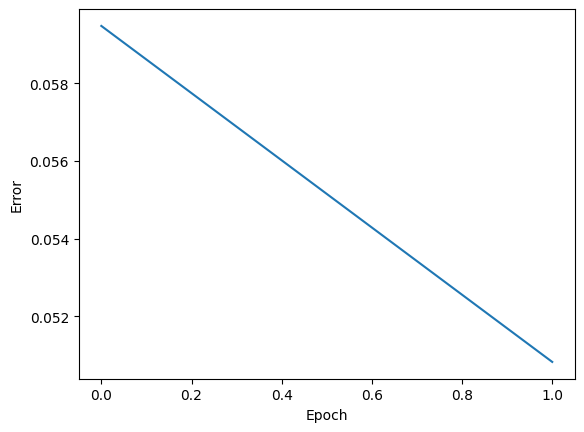

In [ ]:
epochs = 2
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        current_weight = sess.run(update_weight, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        current_vb = sess.run(update_vb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        cur_nb = sess.run(update_hb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        previous_weight = current_weight
        previous_vb = current_vb
        previous_hb = current_hb
    errors.append(sess.run(err_sum, feed_dict={visible_0: trX, W: current_weight, visibleBias: current_vb, hiddenBias: current_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [ ]:
mock_user_id = 215
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

#Feeding in the user and reconstructing the input
hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
vv1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
feed = sess.run(hidden_0, feed_dict={ visible_0: inputUser, W: previous_weight, hiddenBias: previous_hb})
rec = sess.run(vv1, feed_dict={ hidden_0: feed, W: previous_weight, visibleBias: previous_vb})
print(rec)

[[0.35033658 0.04871448 0.01872281 ... 0.00494722 0.00472312 0.01735544]]


In [ ]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(5)

,MovieID,Title,Genres,RecommendationScore
2789,2858,American Beauty (1999),Comedy|Drama,0.806133
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.788163
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.702700
2693,2762,"Sixth Sense, The (1999)",Thriller,0.666200
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.646524


In [ ]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In [ ]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

In [ ]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(5)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
2651,2858,American Beauty (1999),Comedy|Drama,0.806133,NaN,NaN,NaN
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.788163,215.0,5.0,976899190.0
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.702700,NaN,NaN,NaN
2557,2762,"Sixth Sense, The (1999)",Thriller,0.666200,NaN,NaN,NaN
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.646524,215.0,5.0,976899689.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import BernoulliRBM

# Load the MovieLens 1M dataset
ratings_data = pd.read_csv('ratings.dat', sep='::', engine='python',
                           names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Prepare the data for RBM training
user_item_matrix = ratings_data.pivot(index='UserID', columns='MovieID', values='Rating')
user_item_matrix.fillna(0, inplace=True)
X_train, X_test = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# Train the RBM
rbm = BernoulliRBM(n_components=100, n_iter=10, learning_rate=0.01, random_state=42)
rbm.fit(X_train)

# Generate predictions for the next 10 movies for a user
user_id = 1  # Example user ID
user_ratings = X_train.loc[user_id]  # Get the user's ratings

# Convert ratings to binary representation (1 for rated movies, 0 for unrated movies)
user_ratings_binary = user_ratings.apply(lambda x: 1 if x > 0 else 0)

# Perform Gibbs sampling to generate predictions
n_samples = 10  # Number of predictions to generate
for _ in range(n_samples):
    hidden_units = rbm.transform(user_ratings_binary.values.reshape(1, -1))
    visible_units = rbm.inverse_transform(hidden_units)
    predicted_ratings = visible_units.flatten()

    # Find the highest-rated unrated movie
    top_movie_id = np.argmax(predicted_ratings * (1 - user_ratings_binary))

    # Add the movie to the user's ratings
    user_ratings_binary[top_movie_id] = 1

    # Print the predicted movie
    predicted_movie_id = user_ratings_binary.index[top_movie_id]
    print(f"Predicted Movie ID: {predicted_movie_id}")



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import BernoulliRBM

# Load the MovieLens 1M dataset
ratings_data = pd.read_csv('/content/drive/MyDrive/movie-lens/ratings.dat', sep='::', engine='python',
                           names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Prepare the data for short-term modeling (RBM)
user_item_matrix = ratings_data.pivot(index='UserID', columns='MovieID', values='Rating')
user_item_matrix.fillna(0, inplace=True)
X_train, X_test = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# Train the RBM for short-term modeling
rbm = BernoulliRBM(n_components=100, n_iter=10, learning_rate=0.01, random_state=42)
rbm.fit(X_train)

# Prepare the data for long-term modeling (collaborative filtering)
item_user_matrix = user_item_matrix.transpose()

# Compute item-item similarity using cosine similarity
item_similarity = cosine_similarity(item_user_matrix)


# Function to predict next item based on user's past history
def predict_next_items(user_id, past_items, num_items=10):
    # Short-term modeling with RBM
    user_ratings = user_item_matrix.loc[user_id]
    user_ratings_binary = user_ratings.apply(lambda x: 1 if x > 0 else 0)
    hidden_units = rbm.transform(user_ratings_binary.values.reshape(1, -1))
    visible_units = np.matmul(hidden_units, rbm.components_)
    predicted_ratings = visible_units.flatten()

    # Long-term modeling with collaborative filtering
    item_indices = np.argsort(-item_similarity[past_items].sum(axis=0))[:num_items]

    # Combine short-term and long-term predictions
    combined_ratings = predicted_ratings + item_user_matrix[user_id]
    combined_ratings[past_items] = -1  # Set already purchased items to a negative value

    # Select the top predicted items
    top_item_indices = np.argsort(-combined_ratings)[0:num_items]

    return top_item_indices

# Example usage
user_id = 1  # Example user ID
past_items =ratings_data[ratings_data['UserID'] == user_id]['MovieID'].tolist()
next_items = predict_next_items(user_id, past_items, num_items=10)


# Print the predicted next items
print("Predicted Next Items:")
for item_id in next_items:
    print(f"Item ID: {item_id}")

Predicted Next Items:
Item ID: 2651
Item ID: 1106
Item ID: 1120
Item ID: 579
Item ID: 1108
Item ID: 2374
Item ID: 575
Item ID: 106
Item ID: 309
Item ID: 802


In [ ]:
import numpy as np
import tensorflow as tf

# Function to predict next item based on user's past history
def predict_next_items(user_id, num_items=10):
    # Get the consumed items for the specified user ID
    consumed_items = ratings_data[ratings_data['UserID'] == user_id]['MovieID'].tolist()

    # Short-term modeling with RBM
    user_ratings = user_item_matrix.loc[user_id]
    user_ratings_binary = user_ratings.apply(lambda x: 1 if x > 0 else 0)

    # Phase 1: Input Processing
    visible_0 = np.array(user_ratings_binary.values.reshape(1, -1), dtype=np.float32)
    hidden_0 = sess.run(hidden_1, feed_dict={visible_0: visible_0})

    # Phase 2: Reconstruction
    visible_1 = sess.run(visible_1, feed_dict={hidden_0: hidden_0})

    # Predicted ratings
    predicted_ratings = visible_1.flatten()

    # Long-term modeling with collaborative filtering
    item_indices = np.argsort(-item_similarity[consumed_items].sum(axis=0))[:num_items]

    # Combine short-term and long-term predictions
    combined_ratings = predicted_ratings + item_user_matrix[user_id]
    combined_ratings[consumed_items] = -1  # Set already consumed items to a negative value

    # Select the top predicted items
    top_item_indices = np.argsort(-combined_ratings)[:num_items]

    return top_item_indices

# Number of hidden nodes
hiddenNodes = 20
# Number of Visible nodes
visibleNodes = len(user_rating_df.columns)
# Number of unique movies
visibleBias = tf.placeholder("float", [visibleNodes])
# Number of features we're going to learn
hiddenBias = tf.placeholder("float", [hiddenNodes])
# Weight Matrix
W = tf.placeholder("float", [visibleNodes, hiddenNodes])

# Phase 1: Input Processing
visible_0 = tf.placeholder("float", [None, visibleNodes])
_hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
hidden_0 = tf.nn.relu(tf.sign(_hidden_0 - tf.random_uniform(tf.shape(_hidden_0))))

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
visible_1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
hidden_1 = tf.nn.sigmoid(tf.matmul(visible_1, W) + hiddenBias)

# Learning rate
alpha = 1.0
# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(visible_0), hidden_0)
w_neg_grad = tf.matmul(tf.transpose(visible_1), hidden_1)
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(visible_0)[0])
# Create methods to update the weights and biases
update_weight = W + alpha * CD
update_vb = visibleBias + alpha * tf.reduce_mean(visible_0 - visible_1, 0)
update_hb = hiddenBias + alpha * tf.reduce_mean(hidden_0 - hidden_1, 0)

err = visible_0 - visible_1
err_sum = tf.reduce_mean(err * err)

# Current weight
current_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
# Current visible unit biases
current_vb = np.zeros([visibleNodes], np.float32)
# Current hidden unit biases
current_hb = np.zeros([hiddenNodes], np.float32)
# Previous weight
previous_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
# Previous visible unit biases
previous_vb = np.zeros([visibleNodes], np.float32)
# Previous hidden unit biases
previous_hb = np.zeros([hiddenNodes], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Example usage
user_id = 1  # Example user ID
next_items = predict_next_items(user_id, num_items=10)

print("Predicted Next Items:")
for item_id in next_items:
    print(f"Item ID: {item_id}")


In [ ]:
import numpy as np
import pandas as pd

# Load the MovieLens 1M dataset
ratings_data = pd.read_csv('/content/drive/MyDrive/movie-lens/ratings.dat', sep='::', engine='python',
                           names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Preprocess the data
user_item_matrix = ratings_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
item_user_matrix = user_item_matrix.transpose()
item_similarity = item_user_matrix.corr()

# Function to predict next item based on user's past history
def predict_next_items(user_id, num_items=10):
    # Get the consumed items for the specified user ID
    consumed_items = ratings_data[ratings_data['UserID'] == user_id]['MovieID'].tolist()

    # Short-term modeling with RBM
    user_ratings = user_item_matrix.loc[user_id]
    user_ratings_binary = user_ratings.apply(lambda x: 1 if x > 0 else 0)

    # Phase 1: Input Processing
    visible_0 = np.array(user_ratings_binary.values.reshape(1, -1), dtype=np.float32)
    hidden_0 = sess.run(hidden_1, feed_dict={visible_0: visible_0})

    # Phase 2: Reconstruction
    visible_1 = sess.run(visible_1, feed_dict={hidden_0: hidden_0})

    # Predicted ratings
    predicted_ratings = visible_1.flatten()

    # Long-term modeling with collaborative filtering
    item_indices = np.argsort(-item_similarity[consumed_items].sum(axis=0))[:num_items]

    # Combine short-term and long-term predictions
    combined_ratings = predicted_ratings + item_user_matrix[user_id]
    combined_ratings[consumed_items] = -1  # Set already consumed items to a negative value

    # Select the top predicted items
    top_item_indices = np.argsort(-combined_ratings)[:num_items]

    return top_item_indices





In [ ]:
# Number of hidden nodes
hiddenNodes = 20
# Number of Visible nodes
visibleNodes = len(user_item_matrix.columns)
# Number of unique movies
visibleBias = tf.placeholder("float", [visibleNodes])
# Number of features we're going to learn
hiddenBias = tf.placeholder("float", [hiddenNodes])
# Weight Matrix
W = tf.placeholder("float", [visibleNodes, hiddenNodes])

# Phase 1: Input Processing
visible_0 = tf.placeholder("float", [None, visibleNodes])
_hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
hidden_0 = tf.nn.relu(tf.sign(_hidden_0 - tf.random_uniform(tf.shape(_hidden_0))))

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
visible_1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
hidden_1 = tf.nn.sigmoid(tf.matmul(visible_1, W) + hiddenBias)

# Learning rate
alpha = 1.0
# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(visible_0), hidden_0)
w_neg_grad = tf.matmul(tf.transpose(visible_1), hidden_1)
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(visible_0)[0])
# Create methods to update the weights and biases
update_weight = W + alpha * CD
update_vb = visibleBias + alpha * tf.reduce_mean(visible_0 - visible_1, 0)
update_hb = hiddenBias + alpha * tf.reduce_mean(hidden_0 - hidden_1, 0)

err = visible_0 - visible_1
err_sum = tf.reduce_mean(err * err)

# Current weight
current_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
# Current visible unit biases
current_vb = np.zeros([visibleNodes], np.float32)
# Current hidden unit biases
current_hb = np.zeros([hiddenNodes], np.float32)
# Previous weight
previous_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
# Previous visible unit biases
previous_vb = np.zeros([visibleNodes], np.float32)
# Previous hidden unit biases
previous_hb = np.zeros([hiddenNodes], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Example usage
user_id = 1  # Example user ID
next_items = predict_next_items(user_id, num_items=10)

print("Predicted Next Items:")
for item_id in next_items:
    print(f"Item ID: {item_id}")

TypeError: ignored